In [48]:
import time
import requests
from bs4 import BeautifulSoup
import csv
import re
import nltk
import matplotlib.pyplot as plt
import random
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from collections import Counter, defaultdict
from math import log

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
sw = stopwords.words("spanish") # Lista de stopwords
ss = SnowballStemmer("spanish") # Stemmer

# Url del la primera página de los comentaris del hotel
url = "https://www.tripadvisor.com.mx/Hotel_Review-g292027-d674247-Reviews-Tranquility_Bay_Beach_Retreat-Trujillo_Colon_Department.html#REVIEWS"

def recolectar_comentarios(url, paginas=2, max_intentos=10):
  """Recolecta los comentarios(documentos) de tripadvisor y los guarda en una lista"""
  comentarios = []

  for i in range(paginas): 
    print(f"Consiguiendo los comentarios de la página {i+1}")
    headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36', 
      "Upgrade-Insecure-Requests": "1",
      "DNT": "1",
      "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
      "Accept-Language": "en-US,en;q=0.5",
      "Accept-Encoding": "gzip, deflate"
    }
    intentos = 0
    while intentos < max_intentos:
      try:
        r = requests.get(url, timeout=1)
        break
      except:
        intentos += 1
        if intentos < max_intentos:
          print(f"ERROR: Hubo un problema al tratar de conseguir los comentarios. Intentando de nuevo... (Intento {intentos+1}/{max_intentos})")
        time.sleep(5)
    if intentos == max_intentos:
      print("ERROR: No se pudo terminar de conseguir todos los comentarios")
      break

    soup = BeautifulSoup(r.content, "html.parser") 
    comentarios_pagina = soup.findAll("q", attrs={'class': 'IRsGHoPm'})
    comentarios_pagina = [ c.text for c in comentarios_pagina] 
    comentarios.append(comentarios_pagina)

    # Conseguir el url de la pagina siguiente
    url =  "https://www.tripadvisor.com.mx" + soup.find("a", attrs={"class": "ui_button nav next primary "})["href"]

  if i == paginas-1:
    print("Comentarios conseguidos con exito!")

  return comentarios


def procesar_comentarios(comentarios, remover_stopwords = True):
  """Procesa una lista de comentarios y retorna una lista de listas de palabras"""
  resultados = []

  for comentario in comentarios:
    comentario = comentario.lower() # Pasarlo a minuscula
    comentario = re.sub(r"[^a-z áéíóúñü]", "", comentario) # Elimina todo lo que no sea letras o espacios
    comentario = word_tokenize(comentario, "spanish") # Separa la oración en palabras
    if remover_stopwords: # Remueve las stopwords
      comentario = [palabra for palabra in comentario if palabra not in sw]
    comentario = [ss.stem(palabra) for palabra in comentario] # Hace stemming a las palabras
    resultados.append(comentario)

  return resultados

def guardar_comentarios(nombre_archivo, comentarios):
  """Guarda una lista de comentarios en un archivo .csv"""
  with open(nombre_archivo, "w") as f:
    writer = csv.writer(f)

    writer.writerow(["comentario"])
    for comentario in comentarios:
      writer.writerow(comentario)

def cargar_comentarios(nombre_archivo):
  with open(nombre_archivo, "r") as f:
    reader = csv.reader(f)
    next(reader)

    comentarios = []
    for r in reader:
      comentarios.append(r[0])

  return comentarios

def palabras_mas_probables(dist, N=10):
  palabras, probabilidad = zip(*Counter(dist).most_common(N))
  plt.figure(figsize=(15, 5))
  plt.bar(palabras, probabilidad)
  plt.xticks(fontsize=19)
  plt.yticks(fontsize=17)
  plt.show()

# Recolección y guardado de comentarios

In [50]:
comentarios = recolectar_comentarios(url, 5)
guardar_comentarios("comentarios.csv", comentarios)

Consiguiendo los comentarios de la página 1
Consiguiendo los comentarios de la página 2
Consiguiendo los comentarios de la página 3
Consiguiendo los comentarios de la página 4
Consiguiendo los comentarios de la página 5
ERROR: Hubo un problema al tratar de conseguir los comentarios. Intentando de nuevo... (Intento 2/10)
Comentarios conseguidos con exito!


# Carga y procesamiento de comentarios

In [51]:
comentarios = cargar_comentarios("comentarios.csv")
comentarios_procesados = procesar_comentarios(comentarios, remover_stopwords=False)

In [52]:
# Cuando hay más de un documento
# c(w, d) - Lista de frecuencias de palabras por comentario frec[n][w] = frecuencia de la palabra w en el comentario n
# frec = [Counter(c) for c in comentarios_procesados]

## PLSA para solo un documento y un tema

In [53]:
# Hacer un solo documento de todos los comentarios (usado para estimar el modelo de fondo)
corpus = [palabra for comentario in comentarios_procesados for palabra in comentario]

# Solo tomamos la mitad de los comentarios para evitar el problema que se dio con el modelo de fondo al utilizar todos los datos
N = len(comentarios_procesados) // 2
C = [palabra for comentario in comentarios_procesados[:N] for palabra in comentario]

In [54]:
vocab = set(C)

In [55]:
# Estimación del tema de fondo p(w | theta_B) con el corpus
frec = Counter(C) # Este solo aplica para el caso de un solo documento
Ptheta_B = Counter(corpus)
for palabra in Ptheta_B:
  Ptheta_B[palabra] /= len(corpus)

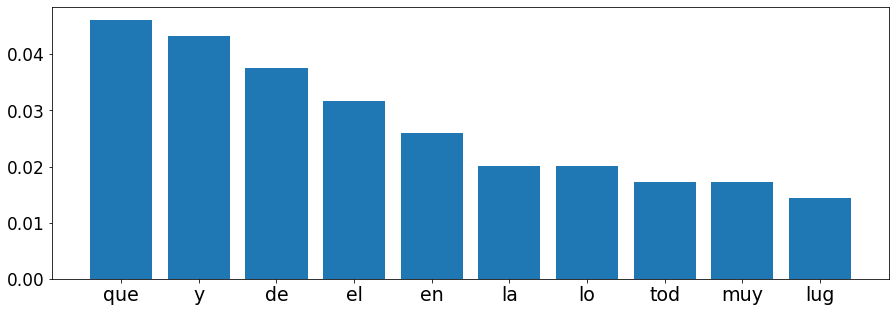

In [56]:
# Gráfica de las 10 palabras más frecuentes
palabras_mas_probables(Ptheta_B)

In [57]:
# P(theta_d)
theta_d = 0.1
# P(theta_B) se debe cumplir P(theta_d) + P(theta_B) = 1
theta_B = 1.0 - theta_d
# P(z = 0 | w)
Pz_0 = defaultdict(lambda : 0.0, {palabra:0.0 for palabra in vocab})
# P(w | theta_d)
Ptheta_d = defaultdict(lambda : 0.0, {palabra:1/len(vocab) for palabra in vocab})

In [58]:
# Paso E
for i in range(20):
  for w in vocab:
    Pz_0[w] = theta_d * Ptheta_d[w] / (theta_d * Ptheta_d[w] + theta_B * Ptheta_B[w])

  # Paso M
  denominador = 0.0
  for w in vocab:
    denominador += frec[w] * Pz_0[w]

  for w in vocab:
    Ptheta_d[w] = frec[w] * Pz_0[w] / denominador

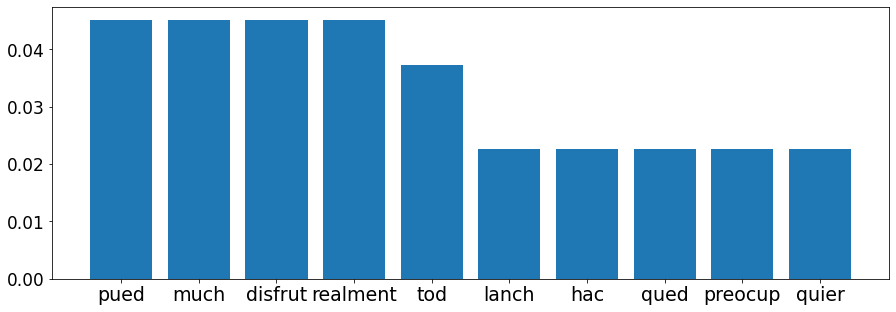

In [59]:
# Tema utilizando modelo(tema) de fondo
palabras_mas_probables(Ptheta_d)

# PLSA sin modelo de fondo y removiendo stopwords (Unigram Model)

In [60]:
comentarios_sin_stopwords = procesar_comentarios(comentarios) # procesamiento quitando stopwords
comentarios_sin_stopwords = [p for c in comentarios_sin_stopwords[:N] for p in c] # Hago un solo documento(comentario)
P = Counter(comentarios_sin_stopwords) # Cuento las frecuencias de cada palabra
for palabra in P:
  P[palabra] /= len(comentarios_sin_stopwords) # Divido entre el tamaño del documento

# P[w] = P(w | theta) = c(w, d) / | d |

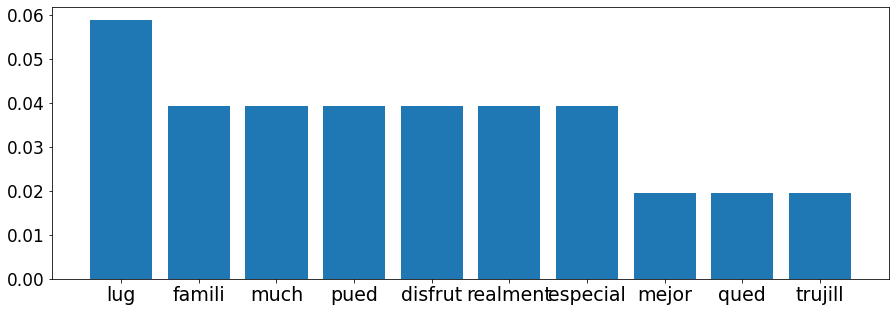

In [61]:
# Tema sin modelo de fondo, quitando stopwords
palabras_mas_probables(P)

# PASO E Y PASO M


In [62]:
comentarios_por_documentos=[]

for d in range(len(comentarios)):
  comentarios_por_documentos.append(comentarios[d])

documentos = procesar_comentarios(comentarios_por_documentos)

In [63]:
documento = []
for j in range(len(documentos)):
  documento.append(set(documentos[j]))

In [64]:
Pz_j=[]
# P(w : theta_j)
Ptheta_j = []
# P(Z_dw=j)
for i in range(len(documento)):
  Pz_j.append(defaultdict(lambda : 0.00, {palabra:0.00 for palabra in documento[i]}))
# P(w | theta_j)
for j in range(len(documento)):
  Ptheta_j.append(defaultdict(lambda : 0.0, {palabra:random.random() for palabra in documento[j]}))

In [65]:
theta_j = []
for i in range(len(documento)):
  theta_j.append(random.random())

In [66]:
P_thetaj = list(map(lambda x: x / sum(theta_j), theta_j))

In [67]:
den = []
for i in range(len(documento)):
  for w in documento[i]:
    den.append(Ptheta_j[i][w]*theta_j[i])

denominador = sum(list(set(den)))
# print(denominador)

In [68]:
# PASO E - 1

for i in range(len(documento)):
  for w in documento[i]:
    Pz_j[i][w] = P_thetaj[i] * Ptheta_j[i][w]/denominador

In [69]:
# PASO E - 2
lambda_B = 0.5
Pz_B = lambda_B * theta_B /(lambda_B * theta_B + (1-lambda_B) * denominador)

In [70]:
V = []
for i in range(len(documento)):
  V.append(set(documento[i]))

In [71]:
# PASO M 
num = []
for i in range(len(documento)):
  for w in V[i]:
    num.append(frec[w]*(1-Pz_B)*Pz_j[i][w])
# P^(n+1) (theta_j)
Pthetaj = sum(num)/(len(documento)*sum(num)) 

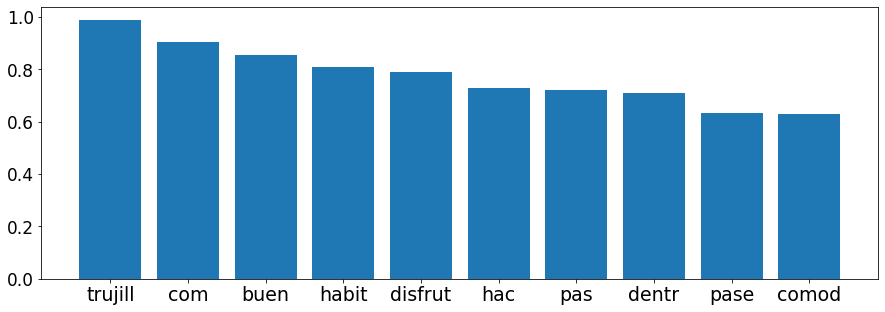

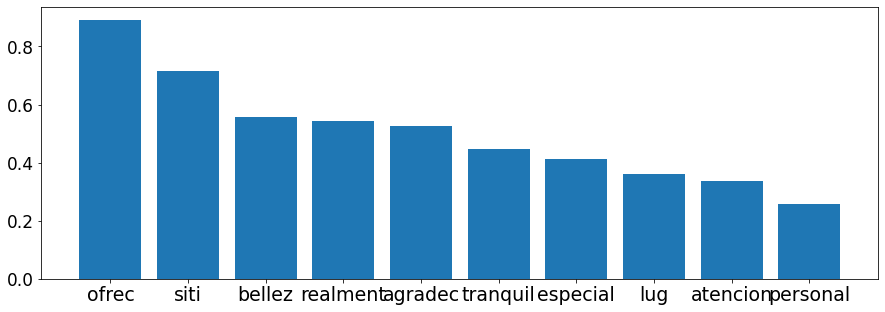

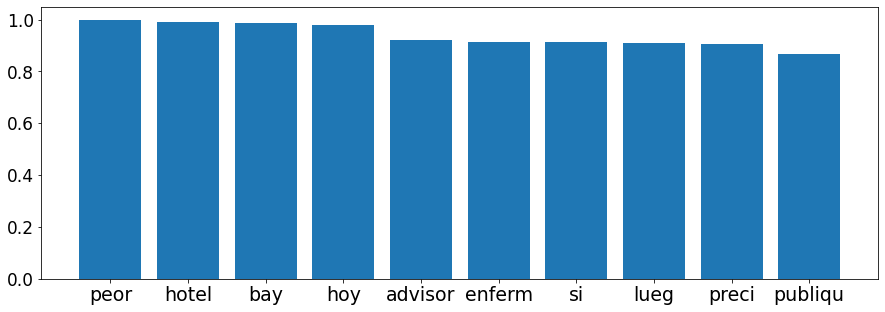

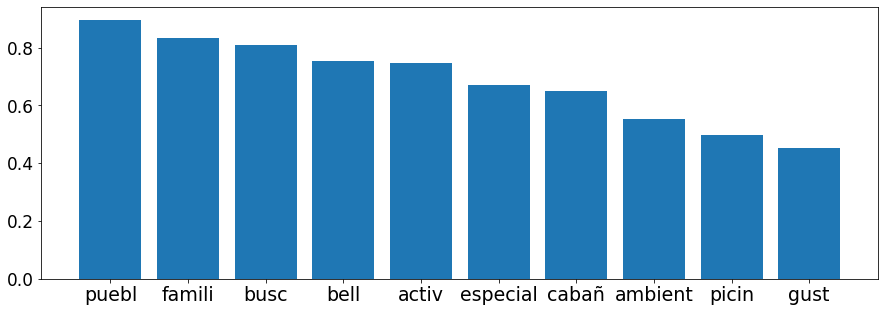

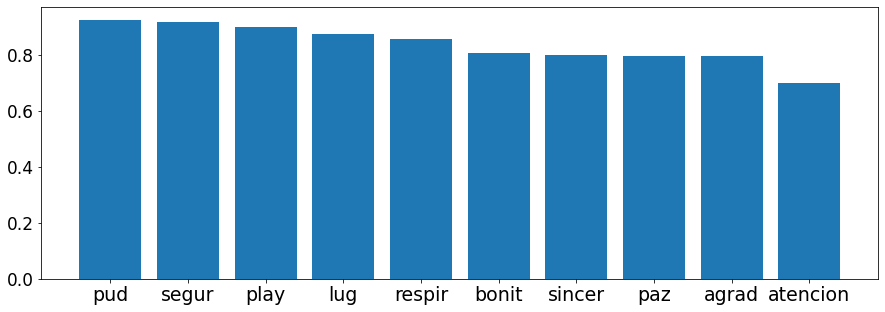

In [77]:
for i in range(len(P_thetaj)):
  palabras_mas_probables(Ptheta_j[i])